In [1]:
%load_ext autoreload
%matplotlib inline

import pickle
import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp, pearsonr, spearmanr
import statsmodels.formula.api as smf

# plotting stuff
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
import echo_utils
from seaborn import despine

# plot settings
font = {'family' : 'Arial',
        'weight' : 'regular',
        'size'   : 14}

plt.rc('font', **font)
fig_path = '../figures/jwm/%s.pdf'
save_plot=True

********************************************************************************
         to build the TVTK classes (8.2). This may cause problems.
         Please rebuild TVTK.
********************************************************************************



# Single-trial Fits of Timescale

### Collect FOOOF fits, and perform outlier detection after merging all (valid) trials across channels & subjects

In [42]:
# load metadata
df_patient_info = pd.read_csv('../data/df_johnson_patient_info.csv', index_col=0)
result_path = '../data/johnson/'

# load data features
feature_names = ['offset', 'exp', 'knee', 'tau', 'theta', 'hfa']
feature_list = []
for ff in feature_names:
    print(ff)
    with open(result_path + "all_%s.txt"%ff, "rb") as fp: # unpickling
        feature_list.append(pickle.load(fp))

# collect all trials into df
col_names = ['patient', 'cond', 'trial', 'chan'] + feature_names
df_alltrials = pd.DataFrame(columns=col_names)

# s3 has really bad data, s15 & s17 are same as s5 & s8
patient_id = range(1,18) # patients go from s1-s17
patient_inds = [0,1,3,4,5,6,7,8,9,10,11,12,13,15]

# collect into a big ass dataframe, row for each trial of every patient and electrode
for i_p in patient_inds:
    patient_mat = patient_id[i_p]*np.ones_like(feature_list[0][i_p])
    nchans, ntrials = feature_list[0][i_p][0].shape
    # make channel metadata matrices
    cond_mat = np.ones_like(feature_list[0][i_p])*np.array([0,1,2])[:,None,None]
    trial_mat = np.repeat(np.outer(np.ones((nchans,1)), np.arange(ntrials)[None,:])[None,:,:], 3, axis=0)
    chan_mat = np.repeat(np.outer(np.ones((ntrials,1)), np.arange(nchans)[None,:]).T[None,:,:], 3, axis=0)
    
    ft_agg = [patient_mat.flatten(), cond_mat.flatten(), trial_mat.flatten(), chan_mat.flatten()]
    # unpack feature and collect into df
    for ft in feature_list:
        ft_agg.append(ft[i_p].flatten())
    df_cur = pd.DataFrame(np.array(ft_agg).T, columns=col_names)
    df_alltrials = df_alltrials.append(df_cur, ignore_index=True)

# discard all trials with really bad slope fits, must be between 0 and 8
df_alltrials[(df_alltrials['exp']<0) | (df_alltrials['exp']>8)] = np.nan

offset
exp
knee
tau
theta
hfa


In [43]:
z_outlier = 100
log_tau = True
global_outlier = False

df_operating = df_alltrials.copy()
grand_avg = []
valid_pat = np.unique(df_operating['patient'])

if global_outlier:
    # global outliers
    x = np.log10(df_operating['tau']) if log_tau else df_operating['tau']
    z = np.abs((x-np.nanmean(x))/np.nanstd(x))
    df_operating['tau'][z>z_outlier]=np.nan

# collect all patients
for i_p in valid_pat:
    df_p = df_operating[(df_operating['patient']==i_p)]
    
    if not global_outlier:
        # within subject outliers
        x = np.log10(df_p['tau']) if log_tau else df_p['tau']        
        z = np.abs((x-np.nanmean(x))/np.nanstd(x))
        df_p['tau'][z>z_outlier]=np.nan        
        
    # pre-stim epoch
    df_pre = df_p[df_p['cond']==0] 

    # get avg values for encoding epoch
    arr_enc = (df_p[df_p['cond']==1].values + df_p[df_p['cond']==2].values)/2
    df_enc = pd.DataFrame(arr_enc, columns=col_names, index=df_pre.index) 

    # compute t-diff and channel average across trials
    t_collect = []
    n_nans = 0
    for g, g_df in df_pre.groupby('trial'):
        
        if log_tau:
            t_pre = np.log10(df_pre.loc[g_df.index]['tau'])
            t_enc = np.log10(df_enc.loc[g_df.index]['tau'])            
        else:
            t_pre = df_pre.loc[g_df.index]['tau']
            t_enc = df_enc.loc[g_df.index]['tau']

        t_diff = t_enc - t_pre

        t_collect.append([np.nanmean(t_pre), np.nanmean(t_enc), np.nanmean(t_diff)])
        n_nans += np.isnan(t_diff).sum()

    t_collect = np.array(t_collect)
    # t-test on tau diff
    tval, pval = ttest_1samp(t_collect[:,-1],0, nan_policy='omit')
    data_qual = (1-n_nans/len(df_pre))*100
    i_p, data_qual, len(df_pre), tval, pval

    grand_avg.append(np.concatenate(([data_qual], np.nanmean(t_collect, 0), [tval])))

ValueError: operands could not be broadcast together with shapes (1427,10) (1420,10) 

In [44]:
# run stats
df_result = pd.DataFrame(np.array(grand_avg), index=df_patient_info.index.values[patient_inds], 
                         columns=['data_qual', 'pre', 'enc', 'diff', 'tvals'])

df_patient = pd.concat((df_patient_info.loc[df_result.index], df_result), axis=1)
df_patient['acc'] = df_patient[['acc_identity','acc_spatial','acc_temporal']].mean(1)
df_patient['rt'] = df_patient[['rt_identity','rt_spatial','rt_temporal']].mean(1)

mod = smf.ols(formula='acc ~ age + diff', data=df_patient)
res = mod.fit()
print(res.summary())

ValueError: Empty data passed with indices specified.

t-test on t-values:  Ttest_1sampResult(statistic=8.837291359455394, pvalue=7.399172566319421e-07)
t-test on diff of means:  Ttest_1sampResult(statistic=9.012136517415456, pvalue=5.930299127674017e-07)
pearson: (0.4844077751697309, 0.07920081266845921)
spearman:  SpearmanrResult(correlation=0.47629808502440873, pvalue=0.08511490272975769)


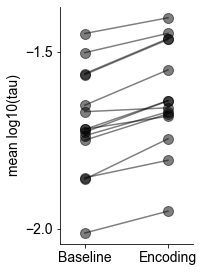

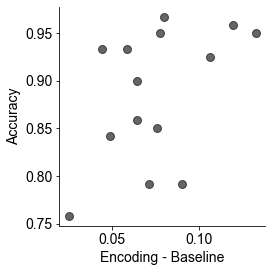

In [9]:
print('t-test on t-values: ',ttest_1samp(df_patient['tvals'], 0, nan_policy='omit'))
print('t-test on diff of means: ', ttest_1samp(df_patient['enc']-df_patient['pre'], 0))

plt.figure(figsize=(3,4))
plt.plot((df_patient['pre'],df_patient['enc']), 'ok-', alpha=0.5, ms=10)
despine()
plt.xticks([0,1], ['Baseline','Encoding']); 
plt.yticks([-2, -1.5])
plt.ylabel('mean log10(tau)')
plt.xlim([-0.3,1.3])
plt.tight_layout()
if save_plot: plt.savefig(fig_path%'pre_enc', bbox_inches='tight')
    
x = df_patient['diff']
y = df_patient['acc']
plt.figure(figsize=(4,4))
plt.plot(x,y, 'ok', alpha=0.6, ms=8)
plt.xlabel('Encoding - Baseline');plt.ylabel('Accuracy');
plt.tight_layout(); despine()
if save_plot: plt.savefig(fig_path%'corr_tdiff_acc', bbox_inches='tight')
    
print('pearson:', pearsonr(x,y))
print('spearman: ', spearmanr(x,y,nan_policy='omit'))


In [45]:
df_patient['data_qual'].values

array([60.42966043, 41.39626352, 43.52300242, 41.85897436, 26.24113475,
       46.5       , 25.55555556, 71.62878788, 42.95671313, 45.3968254 ,
       55.90277778, 64.12037037, 63.68055556, 68.56435644])

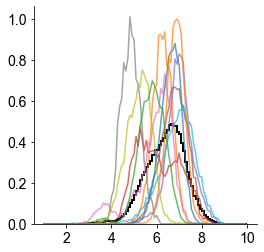

In [48]:
log_feat = False
feat = 'theta'
#bins = np.arange(np.floor(df_alltrials[feat].min()), np.ceil(df_alltrials[feat].max()), 0.02)
if log_feat:
    bins = np.linspace(np.log10(np.floor(df_alltrials[feat].min())), np.log10(np.ceil(df_alltrials[feat].max())), 100)    
else:
    bins = np.linspace(np.floor(df_alltrials[feat].min()), np.ceil(df_alltrials[feat].max()), 100)

    
plt.figure(figsize=(4,4))
for i_p in patient_inds:
    if log_feat:
        counts = np.histogram(np.log10(df_alltrials[df_alltrials['patient']==i_p][feat]), bins, density=True)[0]
    else:
        counts = np.histogram(df_alltrials[df_alltrials['patient']==i_p][feat], bins, density=True)[0]
        
    plt.plot(bins[:-1],counts, alpha=0.7)

if log_feat:
    plt.hist(np.log10(df_alltrials[feat]), bins, histtype='step', ec='k',lw=2, density=True);
else:
    plt.hist(df_alltrials[feat], bins, histtype='step', ec='k',lw=2, density=True);

despine();